# Eye Movement — Desktop Activity Recognition

This notebook implements a full pipeline to load eye-tracking CSVs from the `dataset/` folder, create sliding-window features, train a RandomForest classifier, evaluate performance, and visualize results.

Sections:
1. Create and activate a virtual environment (venv)
2. Imports & kernel setup
3. Constants and dataset path checks
4. Load and combine CSVs
5. Quick inspection & cleaning
6. Compute velocities and sliding-window feature extraction
7. Training, evaluation, and visualizations


## Imports and configuration

This cell imports all libraries used in the notebook (data handling with pandas and numpy, ML tools from scikit-learn, plotting with matplotlib/seaborn, and joblib for saving models). It also sets plotting style and a reproducible random seed so downstream results are consistent across runs.

In [2]:
# 2 — Imports
import os
import re
import glob
import json
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

sns.set(style="whitegrid")
%matplotlib inline

SEED = 42
np.random.seed(SEED)


## Project constants and dataset checks

This cell defines project-level constants (like `DATA_DIR` and `SEED`) and performs quick filesystem sanity checks: it asserts the dataset directory exists, collects `.csv` file paths, and prints a small sample list so you can confirm the expected input files are available before running expensive processing.

In [3]:
# 3 — Constants and dataset path checks
ROOT = Path('.')
DATA_DIR = ROOT / 'dataset'
print('Project root:', ROOT.resolve())
print('Dataset path:', DATA_DIR.resolve())

assert DATA_DIR.exists(), f"DATA_DIR not found: {DATA_DIR.resolve()}"
csv_files = list(DATA_DIR.rglob('*.csv'))
print(f'Found {len(csv_files)} CSV files (showing up to 10):')
for p in csv_files[:10]:
    print(' -', p.name)


Project root: D:\arfa\code\eye_movement
Dataset path: D:\arfa\code\eye_movement\dataset
Found 192 CSV files (showing up to 10):
 - P01_BROWSE.csv
 - P01_DEBUG.csv
 - P01_INTERPRET.csv
 - P01_PLAY.csv
 - P01_READ.csv
 - P01_SEARCH.csv
 - P01_WATCH.csv
 - P01_WRITE.csv
 - P02_BROWSE.csv
 - P02_DEBUG.csv


## Load and combine CSV files (`load_all_data`)

This cell implements `load_all_data`, which recursively finds `.csv` files in the dataset directory, reads each file into a DataFrame, extracts `user` and `task` from the filename, adds `source_file` and a `session_id` to track the recording, and concatenates all per-file DataFrames into a single combined table. It also verifies required columns (e.g., `x`, `y`) and reports files that fail to parse.

In [4]:
# 4 — Load and combine CSV files

def parse_user_task_from_filename(fname):
    # Support patterns like P01_READ.csv, P01-READ.csv, or P01_READ-v1.csv
    base = Path(fname).stem
    # normalize separators
    parts = re.split('[-_]', base)
    if len(parts) >= 2:
        user = parts[0]
        task = parts[1]
    else:
        user = base
        task = 'unknown'
    return user, task


def load_all_data(data_directory):
    data_directory = Path(data_directory)
    all_files = list(data_directory.rglob('*.csv'))
    if len(all_files) == 0:
        raise FileNotFoundError(f'No CSV files found in {data_directory}')
    dfs = []
    for i, fp in enumerate(sorted(all_files)):
        try:
            df = pd.read_csv(fp)
        except Exception as e:
            print(f'Warning: failed to read {fp}: {e}')
            continue
        user, task = parse_user_task_from_filename(fp.name)
        df['user'] = user
        df['task'] = task
        df['source_file'] = fp.name
        df['session_id'] = f'{user}__{task}__{i}'
        dfs.append(df)
    combined = pd.concat(dfs, ignore_index=True)
    # Ensure x/y exist
    if 'x' not in combined.columns or 'y' not in combined.columns:
        raise ValueError('Expected columns x and y in CSV files')
    return combined

# quick smoke load

df_raw = load_all_data(DATA_DIR)
print('Combined rows:', len(df_raw))

df_raw.head()


Combined rows: 1505813


,participant,set,activity,x,y,timestamp,user,task,source_file,session_id
0,P01,B,BROWSE,1016,459,0,P01,BROWSE,P01_BROWSE.csv,P01__BROWSE__0
1,P01,B,BROWSE,1001,464,36,P01,BROWSE,P01_BROWSE.csv,P01__BROWSE__0
2,P01,B,BROWSE,998,476,72,P01,BROWSE,P01_BROWSE.csv,P01__BROWSE__0
3,P01,B,BROWSE,1001,482,107,P01,BROWSE,P01_BROWSE.csv,P01__BROWSE__0
4,P01,B,BROWSE,1011,489,140,P01,BROWSE,P01_BROWSE.csv,P01__BROWSE__0


## Compute per-user velocity and basic preprocessing

This cell sorts the data within each `user`+`session_id`, converts timestamps if present, computes per-user differences `dx`/`dy` (and `dt` when timestamps exist), and derives a `velocity` column (Euclidean distance or distance/dt). It also clips extreme velocity outliers and prepares the DataFrame for windowing by ensuring consistent ordering.

In [5]:
# 5 — Compute gaze velocity and basic preprocessing
# Ensure rows are ordered per session
cols_before = list(df_raw.columns)
if 'timestamp' in df_raw.columns:
    df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'], errors='coerce')
    df_raw = df_raw.sort_values(['user', 'session_id', 'timestamp']).reset_index(drop=True)
else:
    df_raw = df_raw.sort_values(['user', 'session_id']).reset_index(drop=True)

# compute differences per user
df_raw[['dx', 'dy']] = df_raw.groupby('user')[['x', 'y']].diff().fillna(0)
if 'timestamp' in df_raw.columns:
    df_raw['dt'] = df_raw.groupby('user')['timestamp'].diff().dt.total_seconds().fillna(0)
    # avoid division by zero
    df_raw['dt'] = df_raw['dt'].replace(0, np.nan)
    df_raw['velocity'] = np.sqrt(df_raw['dx']**2 + df_raw['dy']**2) / df_raw['dt']
    df_raw['velocity'] = df_raw['velocity'].replace([np.inf, -np.inf], np.nan).fillna(0)
else:
    df_raw['velocity'] = np.sqrt(df_raw['dx']**2 + df_raw['dy']**2)

# clip extreme outliers to a reasonable quantile to avoid noisy features
vel_clip = df_raw['velocity'].quantile(0.999)
df_raw['velocity'] = df_raw['velocity'].clip(upper=vel_clip)

print('Computed velocity. Example:')
df_raw[['user','task','session_id','x','y','dx','dy','velocity']].head()


Computed velocity. Example:


,user,task,session_id,x,y,dx,dy,velocity
0,P01,BROWSE,P01__BROWSE__0,1016,459,0.0,0.0,0.000000e+00
1,P01,BROWSE,P01__BROWSE__0,1001,464,-15.0,5.0,4.392052e+08
2,P01,BROWSE,P01__BROWSE__0,998,476,-3.0,12.0,3.435921e+08
3,P01,BROWSE,P01__BROWSE__0,1001,482,3.0,6.0,1.916630e+08
4,P01,BROWSE,P01__BROWSE__0,1011,489,10.0,7.0,3.698956e+08


## Sliding-window feature extraction (`create_features_from_windows`)

This cell defines the sliding-window extractor that iterates each session, slides a fixed-size window (configurable `window_size` and `step_size`) and computes statistical features per window: mean/std/min/max for `x` and `y`, and mean/std/max for `velocity` (plus sample count). The output is a features DataFrame, a label array, and a list of feature names ready for model training.

In [6]:
# 6 — Create sliding-window features

def create_features_from_windows(df, window_size=50, step_size=25):
    """
    Converts time-series gaze data into windowed statistical features.
    Returns: X_df (DataFrame), y (np.array), feature_names (list)
    """
    feature_rows = []
    labels = []
    session_ids = []
    # group by session (user + session_id)
    grouped = df.groupby('session_id')
    for session, g in grouped:
        g = g.reset_index(drop=True)
        n = len(g)
        if n < window_size:
            continue
        for start in range(0, n - window_size + 1, step_size):
            win = g.iloc[start:start+window_size]
            feats = {}
            # x & y stats
            feats['x_mean'] = win['x'].mean()
            feats['x_std'] = win['x'].std()
            feats['x_min'] = win['x'].min()
            feats['x_max'] = win['x'].max()
            feats['y_mean'] = win['y'].mean()
            feats['y_std'] = win['y'].std()
            feats['y_min'] = win['y'].min()
            feats['y_max'] = win['y'].max()
            # velocity stats
            feats['vel_mean'] = win['velocity'].mean()
            feats['vel_std'] = win['velocity'].std()
            feats['vel_max'] = win['velocity'].max()
            # sample count
            feats['n_samples'] = len(win)
            feature_rows.append(feats)
            # label: task for the session (assume constant within session)
            labels.append(win['task'].iloc[0])
            session_ids.append(session)
    X_df = pd.DataFrame(feature_rows)
    feature_names = list(X_df.columns)
    y = np.array(labels)
    return X_df, y, feature_names

# quick run to create features
X_df, y, feature_names = create_features_from_windows(df_raw, window_size=50, step_size=25)
print('Features shape:', X_df.shape)
print('Number of labels:', len(y))
X_df.head()


Features shape: (59954, 12)
Number of labels: 59954


,x_mean,x_std,x_min,x_max,y_mean,y_std,y_min,y_max,vel_mean,vel_std,vel_max,n_samples
0,933.98,175.321686,425,1614,529.24,259.493113,101,1138,2.589553e+09,5.682575e+09,2.389982e+10,50
1,974.44,390.142055,352,1641,660.84,463.372304,101,1905,3.909478e+09,6.543616e+09,2.389982e+10,50
2,1269.20,444.470196,352,1753,504.12,495.064071,68,1905,2.760753e+09,4.496299e+09,1.918338e+10,50
3,1514.26,242.649055,537,1753,191.38,224.608675,68,1050,1.582220e+09,2.671137e+09,1.306895e+10,50
4,1582.86,115.921685,1386,1694,126.20,25.557458,84,184,8.455836e+08,1.516768e+09,8.962016e+09,50


## Encode labels, train and evaluate model

This cell encodes textual `task` labels to integers, prepares `X`/`y` (fills NaNs), splits into train/test with stratification to preserve class balance, trains a `RandomForestClassifier`, evaluates using accuracy and a classification report, saves the trained model and supporting objects (label encoder and feature names), and defines plotting utilities for confusion matrix and feature importances.

Train shape: (47963, 12) Test shape: (11991, 12)
Accuracy: 0.6297

Classification report:
              precision    recall  f1-score   support

      BROWSE       0.60      0.55      0.57      1707
       DEBUG       0.54      0.61      0.58      1217
   INTERPRET       0.57      0.57      0.57      1125
        PLAY       0.67      0.64      0.66      1671
        READ       0.76      0.91      0.83      1722
      SEARCH       0.58      0.46      0.52      1459
       WATCH       0.62      0.67      0.65      1990
       WRITE       0.60      0.52      0.56      1100

    accuracy                           0.63     11991
   macro avg       0.62      0.62      0.62     11991
weighted avg       0.63      0.63      0.62     11991

Saved model to rf_eye_tracking.joblib


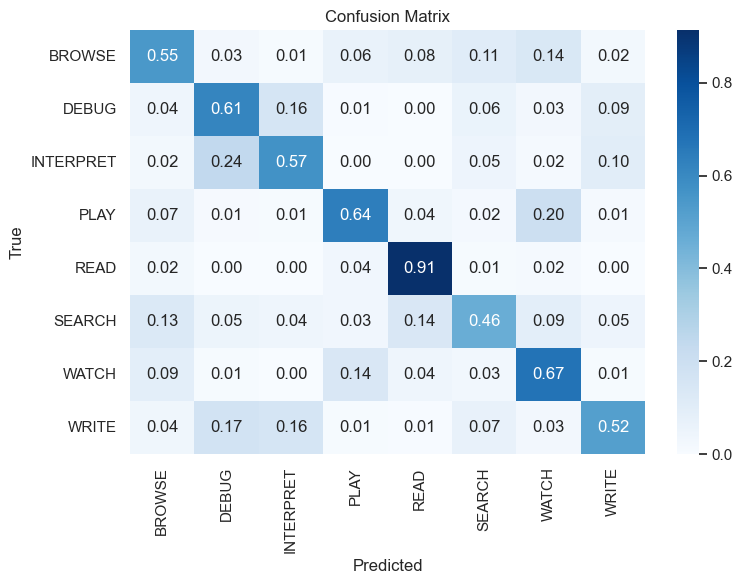

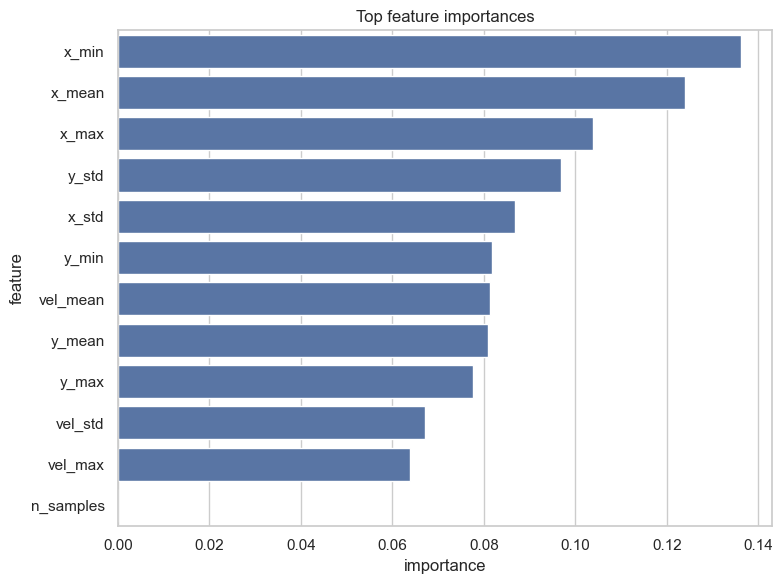

In [7]:
# 7 — Encode labels, split, train and evaluate
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = le.classes_

# split
X = X_df.fillna(0).values
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=SEED)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

# train
model = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# metrics
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc:.4f}')
print('\nClassification report:')
print(classification_report(y_test, y_pred, target_names=class_names))

# save model
joblib.dump({'model': model, 'label_encoder': le, 'feature_names': feature_names}, 'rf_eye_tracking.joblib')
print('Saved model to rf_eye_tracking.joblib')

# 8 — Plotting utilities

def plot_confusion_matrix(y_true, y_pred, class_names, normalize=True):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', xticklabels=class_names, yticklabels=class_names, cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    plt.tight_layout()
    return ax


def plot_feature_importance(model, feature_names, top_n=20):
    importances = model.feature_importances_
    fi = pd.DataFrame({'feature': feature_names, 'importance': importances})
    fi = fi.sort_values('importance', ascending=False).head(top_n)
    fig, ax = plt.subplots(figsize=(8,6))
    sns.barplot(x='importance', y='feature', data=fi, ax=ax)
    ax.set_title('Top feature importances')
    plt.tight_layout()
    return ax

# show plots
plot_confusion_matrix(y_test, y_pred, class_names)
plot_feature_importance(model, feature_names, top_n=15)
plt.show()


## Hyperparameter tuning for RandomForest using GridSearchCV

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Ensure training split exists
assert 'X_train' in globals() and 'y_train' in globals(), 'X_train/y_train not found — run the split cell first'

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=SEED, n_jobs=-1)
grid = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

print('Starting GridSearchCV (this may take several minutes depending on data size)...')
grid.fit(X_train, y_train)

print('\nBest params:', grid.best_params_)
print('Best CV score:', grid.best_score_)

# optional: evaluate on test set if available
if 'X_test' in globals() and 'y_test' in globals():
    best = grid.best_estimator_
    test_acc = best.score(X_test, y_test)
    print(f'Test set accuracy of best estimator: {test_acc:.4f}')
else:
    print('X_test/y_test not found — skip test set evaluation')


Starting GridSearchCV (this may take several minutes depending on data size)...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 300}
Best CV score: 0.6275044976933156
Test set accuracy of best estimator: 0.6360


## SMOTE and XGBoost comparison

This section compares models trained with and without SMOTE and adds XGBoost for a second perspective.

- SMOTE oversamples minority classes in the training set only; it does not change the test set. Use it to improve recall on under-represented tasks.
- When reviewing results, check both overall accuracy and per-class recall/precision in the confusion matrices — accuracy can stay similar while minority classes improve.
- Feature importances may shift after resampling; compare the top features before and after SMOTE to understand model changes.

In [9]:
# 7a — Handle class imbalance with SMOTE on training data
# Applies SMOTE to X_train/y_train and prints shapes before/after
try:
    from imblearn.over_sampling import SMOTE
except Exception as e:
    raise ImportError('imbalanced-learn (imblearn) is not installed. Install with: pip install imbalanced-learn') from e

# If the train/test split is missing, create it from X_df and y
if 'X_train' not in globals() or 'y_train' not in globals():
    if 'X_df' in globals() and 'y' in globals():
        print('Train split missing — creating train/test split from X_df and y before SMOTE')
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        y_enc = le.fit_transform(y)
        class_names = le.classes_
        X = X_df.fillna(0).values
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=SEED)
        print('Created X_train/X_test shapes:', X_train.shape, X_test.shape)
    else:
        raise AssertionError('X_train/y_train not found — run feature extraction to produce X_df and y')

import collections
print('Before SMOTE — X_train shape, y_train shape:', X_train.shape, getattr(y_train, 'shape', (len(y_train),)))
print('Class distribution before:', dict(collections.Counter(y_train)))

sm = SMOTE(random_state=SEED)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print('After SMOTE — X_train_res shape, y_train_res shape:', X_train_res.shape, y_train_res.shape)
print('Class distribution after:', dict(collections.Counter(y_train_res)))

# Replace training variables so subsequent cells use the balanced training set
X_train, y_train = X_train_res, y_train_res


Before SMOTE — X_train shape, y_train shape: (47963, 12) (47963,)
Class distribution before: {np.int64(6): 7960, np.int64(4): 6889, np.int64(7): 4402, np.int64(3): 6683, np.int64(0): 6826, np.int64(5): 5836, np.int64(1): 4867, np.int64(2): 4500}
After SMOTE — X_train_res shape, y_train_res shape: (63680, 12) (63680,)
Class distribution after: {np.int64(6): 7960, np.int64(4): 7960, np.int64(7): 7960, np.int64(3): 7960, np.int64(0): 7960, np.int64(5): 7960, np.int64(1): 7960, np.int64(2): 7960}


## Compare models trained with and without SMOTE

In [10]:
# Trains RandomForest and XGBoost on (1) original training data and (2) SMOTE-resampled training data
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import collections

# Ensure features exist
assert 'X_df' in globals() and 'y' in globals(), 'X_df/y not found — run feature extraction first'

# Prepare a fresh train/test split (we will not overwrite global X_train unless desired)
X = X_df.fillna(0).values
le_cmp = LabelEncoder()
y_enc_cmp = le_cmp.fit_transform(y)
class_names_cmp = le_cmp.classes_
X_train_orig, X_test_cmp, y_train_orig, y_test_cmp = train_test_split(X, y_enc_cmp, test_size=0.2, stratify=y_enc_cmp, random_state=SEED)
print('Original train shape:', X_train_orig.shape, 'Test shape:', X_test_cmp.shape)
print('Class distribution (orig):', dict(collections.Counter(y_train_orig)))

# Apply SMOTE to the fresh training split
try:
    from imblearn.over_sampling import SMOTE
except Exception as e:
    raise ImportError('imbalanced-learn not installed. Install with: pip install imbalanced-learn') from e
sm = SMOTE(random_state=SEED)
X_train_sm, y_train_sm = sm.fit_resample(X_train_orig, y_train_orig)
print('After SMOTE — train shape:', X_train_sm.shape)
print('Class distribution (smote):', dict(collections.Counter(y_train_sm)))

# Models to compare (use small defaults; you can GridSearch later)
rf_orig = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
rf_sm = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)

# XGBoost may not be installed; give informative error if missing
try:
    import xgboost as xgb
except Exception as e:
    raise ImportError('xgboost is not installed. Install with: pip install xgboost') from e
xgb_orig = xgb.XGBClassifier(random_state=SEED, use_label_encoder=False, n_jobs=-1, verbosity=0)
xgb_sm = xgb.XGBClassifier(random_state=SEED, use_label_encoder=False, n_jobs=-1, verbosity=0)

from sklearn.metrics import accuracy_score, classification_report

def train_eval(clf, X_tr, y_tr, X_te, y_te, name):
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    print(f'== {name} ==')
    print(f'Accuracy: {acc:.4f}')
    print(classification_report(y_te, y_pred, target_names=class_names_cmp))
    return acc

print('\nTraining on ORIGINAL (no SMOTE)')
acc_rf_orig = train_eval(rf_orig, X_train_orig, y_train_orig, X_test_cmp, y_test_cmp, 'RandomForest (orig)')
acc_xgb_orig = train_eval(xgb_orig, X_train_orig, y_train_orig, X_test_cmp, y_test_cmp, 'XGBoost (orig)')

print('\nTraining on SMOTE-resampled data')
acc_rf_sm = train_eval(rf_sm, X_train_sm, y_train_sm, X_test_cmp, y_test_cmp, 'RandomForest (SMOTE)')
acc_xgb_sm = train_eval(xgb_sm, X_train_sm, y_train_sm, X_test_cmp, y_test_cmp, 'XGBoost (SMOTE)')

# Summary
print('\nSummary of accuracies:')
results = {
    'RF_orig': acc_rf_orig,
    'XGB_orig': acc_xgb_orig,
    'RF_SMOTE': acc_rf_sm,
    'XGB_SMOTE': acc_xgb_sm
}
for k,v in results.items():
    print(f'{k}: {v:.4f}')


Original train shape: (47963, 12) Test shape: (11991, 12)
Class distribution (orig): {np.int64(6): 7960, np.int64(4): 6889, np.int64(7): 4402, np.int64(3): 6683, np.int64(0): 6826, np.int64(5): 5836, np.int64(1): 4867, np.int64(2): 4500}
After SMOTE — train shape: (63680, 12)
Class distribution (smote): {np.int64(6): 7960, np.int64(4): 7960, np.int64(7): 7960, np.int64(3): 7960, np.int64(0): 7960, np.int64(5): 7960, np.int64(1): 7960, np.int64(2): 7960}

Training on ORIGINAL (no SMOTE)
== RandomForest (orig) ==
Accuracy: 0.6297
              precision    recall  f1-score   support

      BROWSE       0.60      0.55      0.57      1707
       DEBUG       0.54      0.61      0.58      1217
   INTERPRET       0.57      0.57      0.57      1125
        PLAY       0.67      0.64      0.66      1671
        READ       0.76      0.91      0.83      1722
      SEARCH       0.58      0.46      0.52      1459
       WATCH       0.62      0.67      0.65      1990
       WRITE       0.60      0.52

### SMOTE & XGBoost Visual summary

Below are concise, easy-to-read visuals to compare model behavior:

- Accuracy bar chart: quick view of overall accuracy for each model/setting.
- Normalized confusion matrices: shows which classes are confused most (rows = true, columns = predicted).
- Top feature importances (trained on SMOTE): highlights which window features the models rely on most.

In [11]:
# 7b — Train and evaluate XGBoost (compare with RandomForest)
# This cell fits an XGBoost classifier on the same training split and prints accuracy + report.
try:
    import xgboost as xgb
except Exception as e:
    raise ImportError('xgboost is not installed. Install with: pip install xgboost') from e

# If the train/test split is missing, try to create it from existing X_df and y
if 'X_train' not in globals() or 'y_train' not in globals():
    if 'X_df' in globals() and 'y' in globals():
        print('X_train not found — creating train/test split from X_df and y')
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        y_enc = le.fit_transform(y)
        class_names = le.classes_
        X = X_df.fillna(0).values
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=SEED)
        print('Created X_train/X_test shapes:', X_train.shape, X_test.shape)
    else:
        raise AssertionError("X_train/y_train not found — run the split cell first or run feature extraction to produce X_df and y")

# Initialize XGBoost classifier with a fixed random state for reproducibility
xgb_clf = xgb.XGBClassifier(random_state=SEED, use_label_encoder=False, n_jobs=-1, verbosity=1)
# Fit on training data
xgb_clf.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_clf.predict(X_test)

# Metrics
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'XGBoost Accuracy: {acc_xgb:.4f}')
print('\nClassification report (XGBoost):')
print(classification_report(y_test, y_pred_xgb, target_names=class_names))

# optional: save XGBoost model
joblib.dump({'model': xgb_clf, 'label_encoder': le, 'feature_names': feature_names}, 'xgb_eye_tracking.joblib')
print('Saved XGBoost model to xgb_eye_tracking.joblib')


d:\arfa\code\eye_movement\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:32:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.6015

Classification report (XGBoost):
              precision    recall  f1-score   support

      BROWSE       0.58      0.51      0.55      1707
       DEBUG       0.51      0.52      0.51      1217
   INTERPRET       0.53      0.55      0.54      1125
        PLAY       0.64      0.66      0.65      1671
        READ       0.77      0.90      0.83      1722
      SEARCH       0.51      0.45      0.48      1459
       WATCH       0.64      0.61      0.62      1990
       WRITE       0.50      0.51      0.51      1100

    accuracy                           0.60     11991
   macro avg       0.58      0.59      0.58     11991
weighted avg       0.60      0.60      0.60     11991

Saved XGBoost model to xgb_eye_tracking.joblib


## Plots for accuracy bar, normalized confusion matrices, top feature importances

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20340\985403160.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accs, palette='viridis', ax=ax)


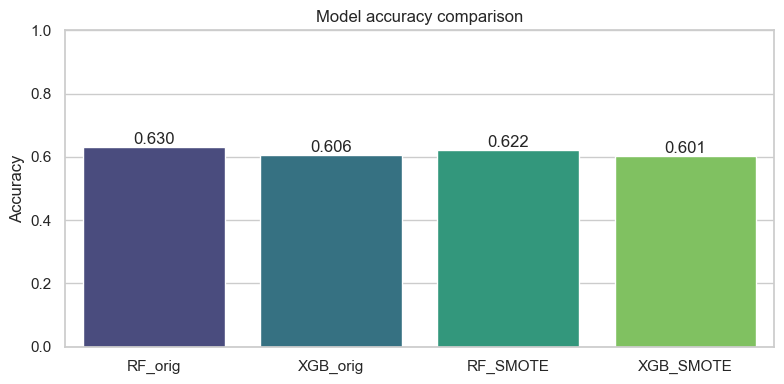

Skipping confusion matrices: X_test_cmp / y_test_cmp or model objects not found in globals.


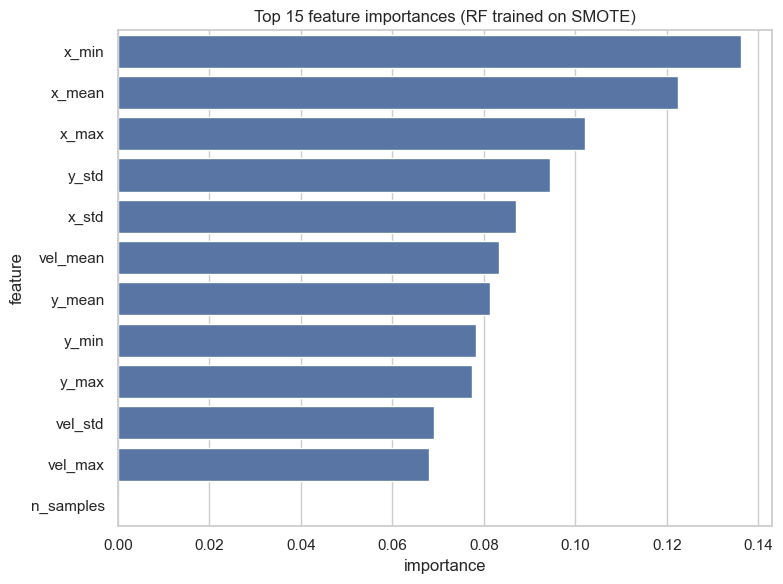

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Check that comparison results exist
if 'results' not in globals():
    print('Comparison results not found. Please run the "Compare models trained with and without SMOTE" cell above, then run this cell.')
else:
    # results should be a dict like {'RF_orig': acc, 'XGB_orig': acc, 'RF_SMOTE': acc, 'XGB_SMOTE': acc}
    labels = list(results.keys())
    accs = [results[k] for k in labels]

    # Accuracy bar chart
    fig, ax = plt.subplots(figsize=(8,4))
    sns.barplot(x=labels, y=accs, palette='viridis', ax=ax)
    ax.set_ylim(0,1)
    ax.set_ylabel('Accuracy')
    ax.set_title('Model accuracy comparison')
    for i,v in enumerate(accs):
        ax.text(i, v + 0.01, f'{v:.3f}', ha='center')
    plt.tight_layout()
    plt.show()

    # If models and a common test set are available, show normalized confusion matrices
    # The comparison cell uses X_test_cmp and y_test_cmp for evaluation
    if 'X_test_cmp' in globals() and 'y_test_cmp' in globals() and 'comparison_models' in globals():
        # comparison_models is optional; try to collect model objects
        cm_models = {}
        # possible keys in global namespace from the comparison cell
        try:
            cm_models['RF_orig'] = rf_orig
            cm_models['RF_SMOTE'] = rf_sm
            cm_models['XGB_orig'] = xgb_orig
            cm_models['XGB_SMOTE'] = xgb_sm
        except NameError:
            # fallback: try comparison_models dict
            try:
                cm_models = comparison_models
            except Exception:
                cm_models = {}

        # Plot up to 4 confusion matrices
        keys = list(cm_models.keys())[:4]
        n = len(keys)
        if n == 0:
            print('No model objects found in globals to plot confusion matrices. Ensure the comparison cell creates rf_orig, rf_sm, xgb_orig, xgb_sm or comparison_models dict.')
        else:
            fig, axes = plt.subplots(1, n, figsize=(5*n, 4))
            if n == 1:
                axes = [axes]
            for ax, k in zip(axes, keys):
                m = cm_models[k]
                y_pred = m.predict(X_test_cmp)
                cm = confusion_matrix(y_test_cmp, y_pred)
                cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                sns.heatmap(cmn, annot=True, fmt='.2f', ax=ax, cmap='Blues', xticklabels=class_names_cmp, yticklabels=class_names_cmp)
                ax.set_title(f'Confusion (norm) — {k}')
                ax.set_xlabel('Predicted')
                ax.set_ylabel('True')
            plt.tight_layout()
            plt.show()
    else:
        print('Skipping confusion matrices: X_test_cmp / y_test_cmp or model objects not found in globals.')

    # Feature importances (from RF_SMOTE if available)
    if 'rf_sm' in globals():
        try:
            fi = pd.DataFrame({'feature': feature_names, 'importance': rf_sm.feature_importances_})
            fi = fi.sort_values('importance', ascending=False).head(15)
            fig, ax = plt.subplots(figsize=(8,6))
            sns.barplot(x='importance', y='feature', data=fi, ax=ax)
            ax.set_title('Top 15 feature importances (RF trained on SMOTE)')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print('Could not plot feature importances:', e)
    else:
        print('RF_SMOTE model not found; skipping feature importances.')
